# 0. Purpose: HMM analysis on hear rate data
- Introduction:  
 The data owner would like to analyze his heart rate data downloaded from his Apple watch, trying to figure out the change of hidden states estimated from HMM (Hidden Markov Model).  
 Especially the owner has heart disease, so it's quite important to detect signs of heart attacks!  
- The states of heart might range from:
 > 1. normal resting (e.g, sleeping)
 > 1. normal static activity
 > 1. normal excercising
 > 1. abnormal other states, ...

- Resource for understaning heart rate:
1. [Target Heart Rates Chart](https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates)
1. [What is a Normal Heart Rate?](https://myheart.net/articles/what-is-a-normal-heart-rate/)
2. [My Watch Told Me to Go to the Hospital](https://myheart.net/articles/my-watch-told-me-to-go-to-the-hospital/)

In [361]:
# Environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Input data manipulation

## - Read data

In [362]:
df = pd.read_csv('HeartWatch-Details-20201002-to-20201228.csv', na_values=['NaN'])

df.head(5)

,ISO,Datum,Zeit,bpm,Schlaf,HF wenn inaktiv,Gehen,Trainings,Max-%,Typ,Notizen
0,2020-10-02T00:00:14+02:00,"Freitag, 2. Okt.",00:00:14,81,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN
1,2020-10-02T00:03:09+02:00,"Freitag, 2. Okt.",00:03:09,82,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN
2,2020-10-02T00:08:17+02:00,"Freitag, 2. Okt.",00:08:17,82,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN
3,2020-10-02T00:12:59+02:00,"Freitag, 2. Okt.",00:12:59,82,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN
4,2020-10-02T00:17:59+02:00,"Freitag, 2. Okt.",00:17:59,84,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN


### * Set datetime index

In [363]:
date_list = [x[:-6] for x in df['ISO'].tolist()]
df['Timestamp'] = pd.to_datetime(date_list) 
df.set_index('Timestamp', inplace=True)
df.head(5)

,ISO,Datum,Zeit,bpm,Schlaf,HF wenn inaktiv,Gehen,Trainings,Max-%,Typ,Notizen
Timestamp,,,,,,,,,,,
2020-10-02 00:00:14,2020-10-02T00:00:14+02:00,"Freitag, 2. Okt.",00:00:14,81,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN
2020-10-02 00:03:09,2020-10-02T00:03:09+02:00,"Freitag, 2. Okt.",00:03:09,82,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN
2020-10-02 00:08:17,2020-10-02T00:08:17+02:00,"Freitag, 2. Okt.",00:08:17,82,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN
2020-10-02 00:12:59,2020-10-02T00:12:59+02:00,"Freitag, 2. Okt.",00:12:59,82,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN
2020-10-02 00:17:59,2020-10-02T00:17:59+02:00,"Freitag, 2. Okt.",00:17:59,84,NaN,1.0,NaN,NaN,NaN,hoher ruhefaktor,NaN


## - Data manipulation

In [364]:
print(df.shape)

(22850, 11)


### * Check column information
Drop unnecessary columns if any

In [365]:
# detect non-Nan values in selected columns
print("The number of non-missing (i.e., valid) values in 'Schlaf': \t", df["Schlaf"].notna().sum())
print("The number of non-missing (i.e., valid) values in 'HF wenn inaktiv': \t", df["HF wenn inaktiv"].notna().sum())
print("The number of non-missing (i.e., valid) values in 'Gehen': \t", df["Gehen"].notna().sum())
print("The number of non-missing (i.e., valid) values in 'Trainings': \t", df["Trainings"].notna().sum())
print("The number of non-missing (i.e., valid) values in 'Max-%': \t", df["Max-%"].notna().sum())
print("The number of non-missing (i.e., valid) values in 'Notizen': \t", df["Notizen"].notna().sum())

The number of non-missing (i.e., valid) values in 'Schlaf': 	 0
The number of non-missing (i.e., valid) values in 'HF wenn inaktiv': 	 16577
The number of non-missing (i.e., valid) values in 'Gehen': 	 340
The number of non-missing (i.e., valid) values in 'Trainings': 	 0
The number of non-missing (i.e., valid) values in 'Max-%': 	 0
The number of non-missing (i.e., valid) values in 'Notizen': 	 0


In [366]:
df["Gehen"] = df["Gehen"].fillna(0)  # nan is replaced with 0
df["HF wenn inaktiv"] = df["HF wenn inaktiv"].fillna(0)

"**Datum**" column can be dropped, since the information can be retrieved by ```df.index.dayofweek , df.index.month, df.index.day```

In [367]:
# columns dropped due to redundant or no information at all!
df.drop(['ISO', 'Datum', 'Zeit', 'Schlaf', 'Trainings',  'Max-%', 'Notizen'], axis='columns', inplace=True)

In [368]:
df['Typ'].value_counts(dropna=False)

hoher ruhefaktor    14292
ruhend               5808
erhöht               2747
niedrig                 3
Name: Typ, dtype: int64

In [369]:
df['Typ'] = df['Typ'].map({'hoher ruhefaktor':0, 'ruhend':1, 'erhöht':2, 'niedrig':3})

In [370]:
df.head(10)

,bpm,HF wenn inaktiv,Gehen,Typ
Timestamp,,,,
2020-10-02 00:00:14,81,1.0,0.0,0
2020-10-02 00:03:09,82,1.0,0.0,0
2020-10-02 00:08:17,82,1.0,0.0,0
2020-10-02 00:12:59,82,1.0,0.0,0
2020-10-02 00:17:59,84,1.0,0.0,0
2020-10-02 00:22:59,83,1.0,0.0,0
2020-10-02 00:28:34,82,1.0,0.0,0
2020-10-02 00:33:23,80,1.0,0.0,0
2020-10-02 00:38:34,80,1.0,0.0,0


## - Descriptive Statistics

In [371]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22850 entries, 2020-10-02 00:00:14 to 2020-12-28 17:19:46
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bpm              22850 non-null  int64  
 1   HF wenn inaktiv  22850 non-null  float64
 2   Gehen            22850 non-null  float64
 3   Typ              22850 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 892.6 KB


In [372]:
df.describe()

,bpm,HF wenn inaktiv,Gehen,Typ
count,22850.000000,22850.000000,22850.000000,22850.000000
mean,87.987615,0.725470,0.014880,0.495011
std,13.396921,0.446287,0.121074,0.700872
min,48.000000,0.000000,0.000000,0.000000
25%,79.000000,0.000000,0.000000,0.000000
50%,85.000000,1.000000,0.000000,0.000000
75%,93.000000,1.000000,0.000000,1.000000
max,195.000000,1.000000,1.000000,3.000000


## - Raw data visualization

Refer to [cmap](https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html) for more colormap options

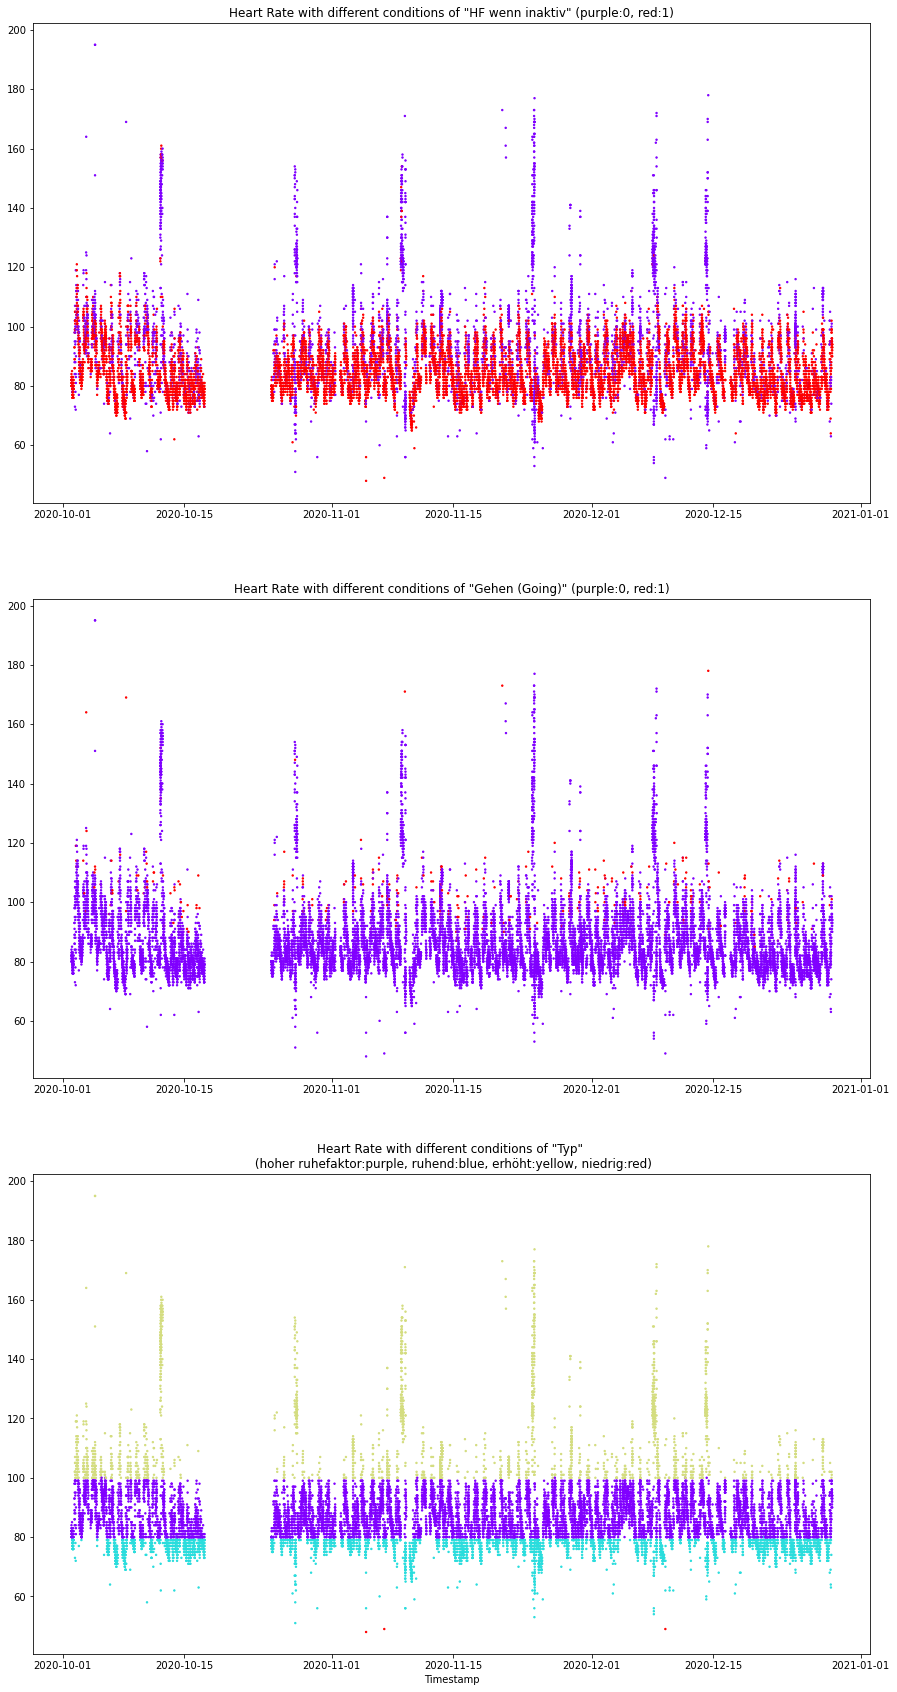

In [375]:
fig, ax = plt.subplots(3,1, figsize=(15,30))
ax[0].scatter(df.index, df['bpm'], c=df['HF wenn inaktiv'], s=2, cmap='rainbow') 
ax[1].scatter(df.index, df['bpm'], c=df['Gehen'], s=2, cmap='rainbow')
ax[2].scatter(df.index, df['bpm'], c=df['Typ'], s=2, cmap='rainbow') 
ax[2].set_xlabel('Timestamp')
ax[0].set_title('Heart Rate with different conditions of "HF wenn inaktiv" (purple:0, red:1)')
ax[1].set_title('Heart Rate with different conditions of "Gehen (Going)" (purple:0, red:1)')
ax[2].set_title('Heart Rate with different conditions of "Typ" \n (hoher ruhefaktor:purple, ruhend:blue, erhöht:yellow, niedrig:red)')
plt.show()
fig.savefig("Raw data visualization.png", dpi = 300, transparent=True)

In [376]:
print("The minimum bpm when 'Gehen(Goinig)=1' is: \t", df[df['Gehen']==1].min().bpm)

The minimum bpm when 'Gehen(Goinig)=1' is: 	 85.0


### * Observations

1. From raw data, it's clear there are 6 apparent high peaks (about bpm > 140) happening during the data period which indicate potential heart attacks. It's hoped that HMM-estimated hidden states can correctly capture those moments.  
1. The "Gehen (Going)" state (i.e, 1) only happens when heart rate is relatively higher ($bpm > 85.0$).
  > But note that when bpm is high, it doesn't necessarily suggest the state of "Gehen (Going)"
1. Intervals of heart rate (bpm) for different Typ are in the following range (by naked eye): 
  > niedrig (3)- (0, 50)  
  > ruhend (1)- (50,80)  
  > hoher ruhefaktor (0)-(80,100)  
  > erhöht (2)-(100,inf)  
1. Via zooming in can we see that there's a long period of time with sequent missing data aroun [2020-10-17 08:43:01, 2020-10-25 01:03:16]

## - Zoom in
* You can zoom in to inspect daily pattern
* You can also check the period of missing data

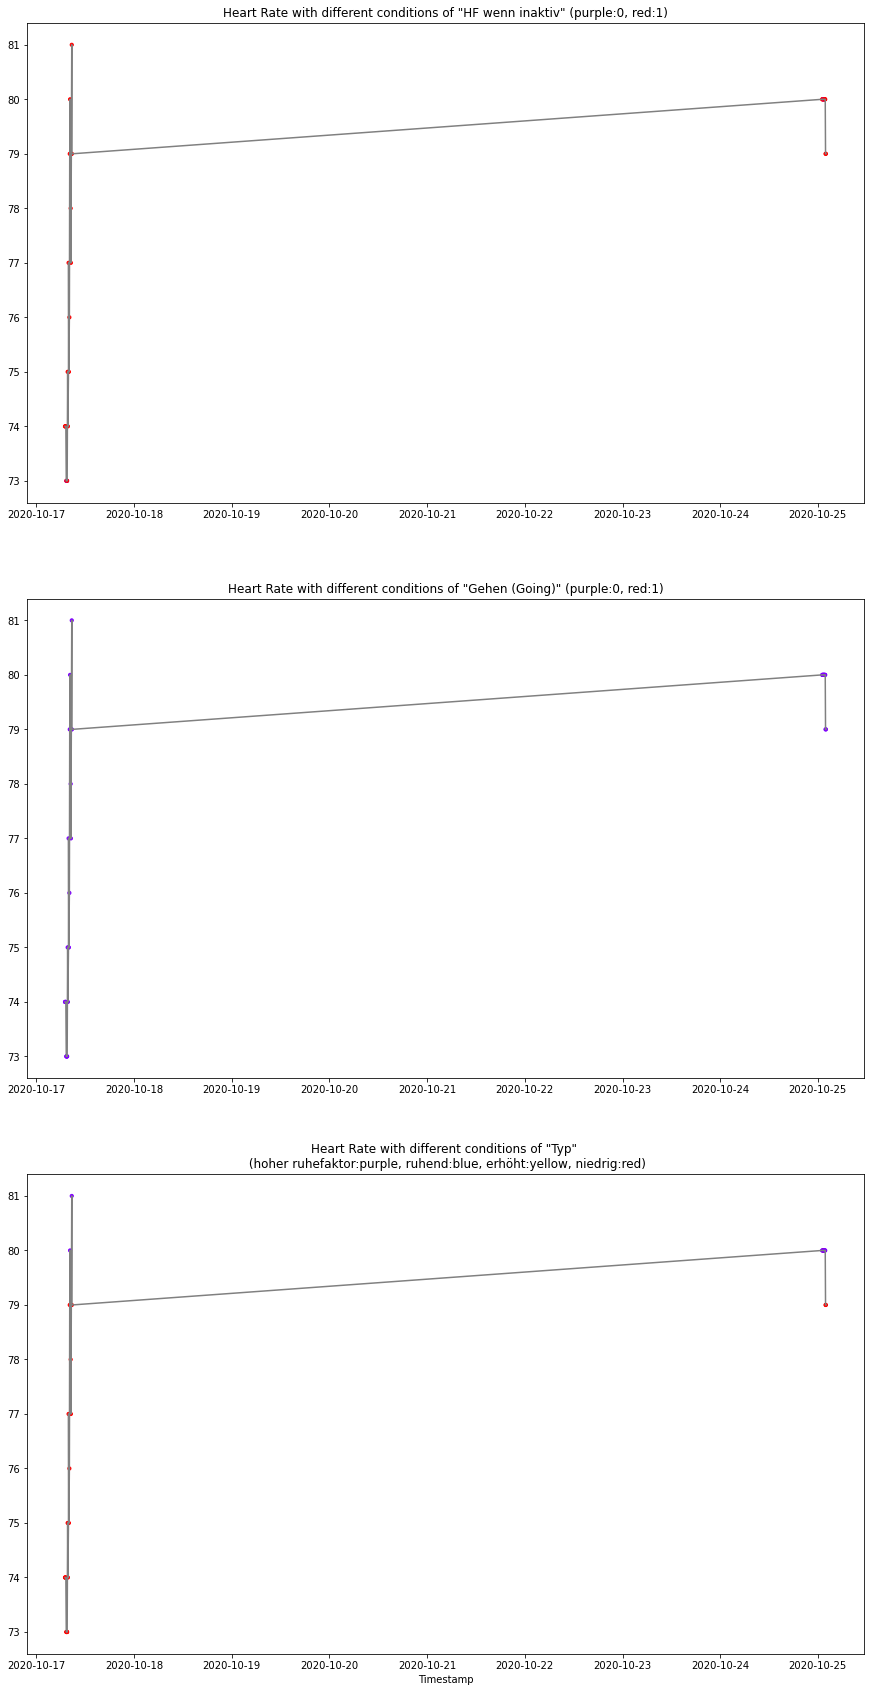

In [377]:
#zoom = df.loc['2020-10-26': '2020-10-27'] #for inspecting daily patter

zoom = df.loc['2020-10-17 7:00': '2020-10-25 02:00'] #for inspecting missing data

fig, ax = plt.subplots(3,1, figsize=(15,30))
ax[0].plot(zoom.index, zoom['bpm'], linestyle='-', c='grey')
ax[0].scatter(zoom.index, zoom['bpm'], c=zoom['HF wenn inaktiv'],s=10, cmap='rainbow') 
ax[1].plot(zoom.index, zoom['bpm'], linestyle='-', c='grey')
ax[1].scatter(zoom.index, zoom['bpm'], c=zoom['Gehen'], s=10, cmap='rainbow')
ax[2].plot(zoom.index, zoom['bpm'], linestyle='-', c='grey')
ax[2].scatter(zoom.index, zoom['bpm'], c=zoom['Typ'], s=10, cmap='rainbow') 
ax[2].set_xlabel('Timestamp')
ax[0].set_title('Heart Rate with different conditions of "HF wenn inaktiv" (purple:0, red:1)')
ax[1].set_title('Heart Rate with different conditions of "Gehen (Going)" (purple:0, red:1)')
ax[2].set_title('Heart Rate with different conditions of "Typ" \n (hoher ruhefaktor:purple, ruhend:blue, erhöht:yellow, niedrig:red)')

plt.show()

### * Select only the period of time needed (without long term of missing data)
#### <span style="color:red">At the model training stage, we'll choose only the data after *'2020-10-25 01:03:16'.*  !!!!!!!!!!!!!!!!!!!!</span>

In [378]:
df.loc['2020-10-17 08:30':'2020-10-25 01:10']

,bpm,HF wenn inaktiv,Gehen,Typ
Timestamp,,,,
2020-10-17 08:34:51,79,1.0,0.0,1
2020-10-17 08:40:57,81,1.0,0.0,0
2020-10-17 08:43:01,79,1.0,0.0,1
2020-10-25 01:03:16,80,1.0,0.0,0
2020-10-25 01:08:01,80,1.0,0.0,0


# 2. Data Preprocessing

## - Regularize time intervals

### * __Handle duplicate label (index in our case) issues if any__

We have to make sure the time index is unique before we can re-index them (it won't work if with duplicate axis/index)

In [379]:
print("Is the index label unique? (i.e, no duplicate index labels): \n", df.index.is_unique)
'''
df.index.duplicated() #array([False, False, False, ..., False, False, False])
df =df.loc[~df.index.duplicated(), :]
df.index.is_unique
'''

Is the index label unique? (i.e, no duplicate index labels): 
 False


'\ndf.index.duplicated() #array([False, False, False, ..., False, False, False])\ndf =df.loc[~df.index.duplicated(), :]\ndf.index.is_unique\n'

Since there are duplicate label, then we have to integrate the data with the duplicate index labels

In [381]:
temp1 = df['bpm'].groupby(level=0).mean()
temp2 = df[['HF wenn inaktiv', 'Gehen', 'Typ']].groupby(level=0).agg(lambda x:x.value_counts().index[0]) #mode
print(temp1.head(5))
print(temp2.head(5))

Timestamp
2020-10-02 00:00:14    81.0
2020-10-02 00:03:09    82.0
2020-10-02 00:08:17    82.0
2020-10-02 00:12:59    82.0
2020-10-02 00:17:59    84.0
Name: bpm, dtype: float64
                     HF wenn inaktiv  Gehen  Typ
Timestamp                                       
2020-10-02 00:00:14              1.0    0.0    0
2020-10-02 00:03:09              1.0    0.0    0
2020-10-02 00:08:17              1.0    0.0    0
2020-10-02 00:12:59              1.0    0.0    0
2020-10-02 00:17:59              1.0    0.0    0


In [382]:
df = pd.concat([temp1, temp2], axis=1)
print("Is the index label unique? (i.e, no duplicate index labels): \n", df.index.is_unique)
df.head(10)

Is the index label unique? (i.e, no duplicate index labels): 
 True


,bpm,HF wenn inaktiv,Gehen,Typ
Timestamp,,,,
2020-10-02 00:00:14,81.0,1.0,0.0,0
2020-10-02 00:03:09,82.0,1.0,0.0,0
2020-10-02 00:08:17,82.0,1.0,0.0,0
2020-10-02 00:12:59,82.0,1.0,0.0,0
2020-10-02 00:17:59,84.0,1.0,0.0,0
2020-10-02 00:22:59,83.0,1.0,0.0,0
2020-10-02 00:28:34,82.0,1.0,0.0,0
2020-10-02 00:33:23,80.0,1.0,0.0,0
2020-10-02 00:38:34,80.0,1.0,0.0,0


### * __Make constant of the time intervals by upsampling to scale of 1 sec.__

In [383]:
min_index = df.index.min()
max_index = df.index.max()
print(min_index)
print(max_index)

2020-10-02 00:00:14
2020-12-28 17:19:46


In [384]:
# Create regular period: 
reg_period = pd.date_range(min_index, max_index, freq='S') #'T'='min', 'S': sec.
reg_period

DatetimeIndex(['2020-10-02 00:00:14', '2020-10-02 00:00:15',
               '2020-10-02 00:00:16', '2020-10-02 00:00:17',
               '2020-10-02 00:00:18', '2020-10-02 00:00:19',
               '2020-10-02 00:00:20', '2020-10-02 00:00:21',
               '2020-10-02 00:00:22', '2020-10-02 00:00:23',
               ...
               '2020-12-28 17:19:37', '2020-12-28 17:19:38',
               '2020-12-28 17:19:39', '2020-12-28 17:19:40',
               '2020-12-28 17:19:41', '2020-12-28 17:19:42',
               '2020-12-28 17:19:43', '2020-12-28 17:19:44',
               '2020-12-28 17:19:45', '2020-12-28 17:19:46'],
              dtype='datetime64[ns]', length=7579173, freq='S')

In [385]:
df = df.reindex(reg_period)

In [386]:
df.head(5)

,bpm,HF wenn inaktiv,Gehen,Typ
2020-10-02 00:00:14,81.0,1.0,0.0,0.0
2020-10-02 00:00:15,NaN,NaN,NaN,NaN
2020-10-02 00:00:16,NaN,NaN,NaN,NaN
2020-10-02 00:00:17,NaN,NaN,NaN,NaN
2020-10-02 00:00:18,NaN,NaN,NaN,NaN


### * __Integrate the data again by downsampling to 5 min. scale (i.e., 5 min.)__  

* Way of integrate data when downsampling:
> 1. For continues variable– "bpm", integrate by mean
> 1. For categorical variables–'HF wenn inaktiv', 'Gehen', 'Typ', output by mode

In [387]:
temp1 = df['bpm'].resample('5T').mean()
temp2 = df[['HF wenn inaktiv', 'Gehen', 'Typ']].resample('5T').agg(lambda x: x.value_counts().index[0] if len(x.value_counts().index)>0 else np.nan) #mode

In [388]:
df = pd.concat([temp1, temp2], axis=1)
df.head(5)

,bpm,HF wenn inaktiv,Gehen,Typ
2020-10-02 00:00:00,81.5,1.0,0.0,0.0
2020-10-02 00:05:00,82.0,1.0,0.0,0.0
2020-10-02 00:10:00,82.0,1.0,0.0,0.0
2020-10-02 00:15:00,84.0,1.0,0.0,0.0
2020-10-02 00:20:00,83.0,1.0,0.0,0.0


In [389]:
print(temp1.isna().sum())
print(temp2.isna().sum())

8501
HF wenn inaktiv    8501
Gehen              8501
Typ                8501
dtype: int64


## - Missing Data Munipulation

Since there are still lots of cases with missing data (#=8501), we look again into data throug visual aids

### * __Interval-regularized  Data Visualization__

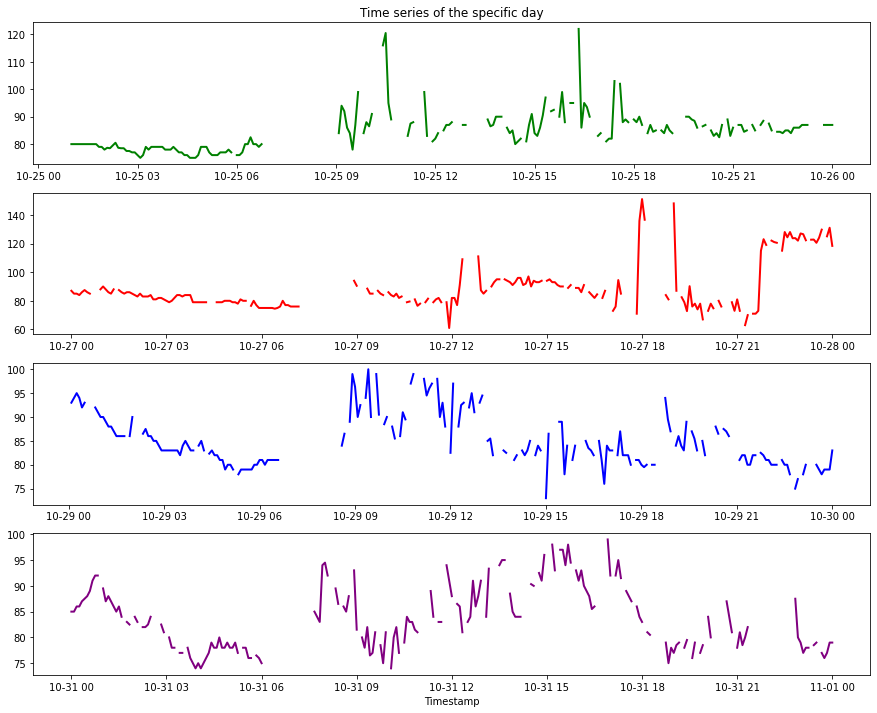

In [392]:
zoom1 = df.loc['2020-10-25 00:00': '2020-10-26 00:00', 'bpm'] 
zoom2 = df.loc['2020-10-27 00:00': '2020-10-28 00:00', 'bpm']
zoom3 = df.loc['2020-10-29 00:00': '2020-10-30 00:00', 'bpm'] 
zoom4 = df.loc['2020-10-31 00:00': '2020-11-01 00:00', 'bpm'] 

fig, ax = plt.subplots(4,1, figsize=(15,12))
ax[0].plot(zoom1.index, zoom1, linestyle='-', c='green', linewidth = 2)
ax[1].plot(zoom2.index, zoom2, linestyle='-', c='red', linewidth = 2)
ax[2].plot(zoom3.index, zoom3, linestyle='-', c='blue', linewidth = 2)
ax[3].plot(zoom4.index, zoom4, linestyle='-', c='purple', linewidth = 2)
ax[0].set_title('Time series of the specific day')
ax[3].set_xlabel('Timestamp')

plt.show()

#### * Observations

1. It's apperantly the data owner has a regular missing data pattern almost every moring, and according to his testimony, he usually doesn't wear the watch in the early (e.g., to load data, ...) which cause data loss.
> daily missing data pattern happens roughly 2 hrs between 7am to 9 am or 6 am to 8am (by naked eye)

#### * Strategy

1. Since the owner claims he live a pretty regular lif, to fill in the "bpm" missing data, we first build a representative daily behavior (with 5-min. interval, thus we have 12*24 mean data points for a day) such as mean or median; those "bpm" missing data will then be replaced with everage/median values at the corresponding time point.

1. For categrorical variable– "HF wenn inaktiv", "Gehen", forward fill (ffill) method would be enough  

1. For categrorical variable– "Typ", it's been a clear rule for how to label the missing data corresponding to the bpm values (as manipulated latter)

In [393]:
df['Hour'] = df.index.hour
df['Minute'] = df.index.minute

(288, 1)


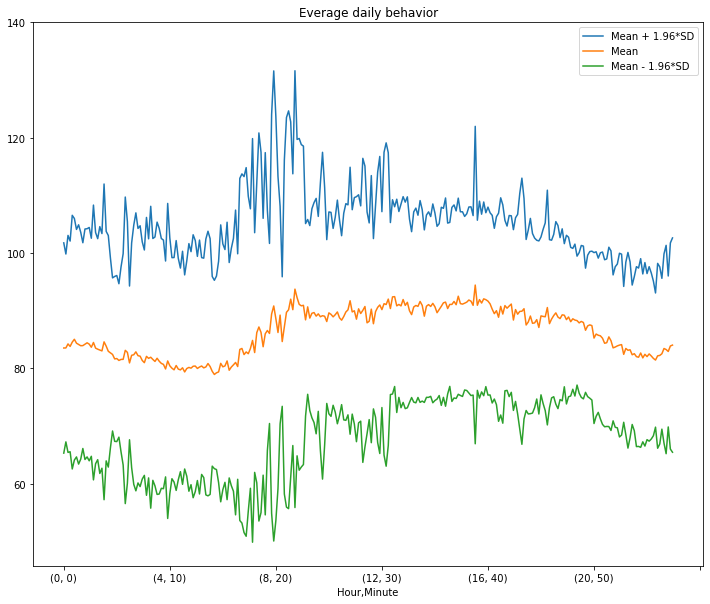

In [411]:
df_daily_bpm = df[['bpm', 'Hour', 'Minute']].groupby(['Hour', 'Minute']).mean() #Now df_daily has MultiIndex([(0,  0),...,(0, 45)],names=['Hour', 'Minute'])
df_daily_bpm_std = df[['bpm', 'Hour', 'Minute']].groupby(['Hour', 'Minute']).std() #Now df_daily has MultiIndex([(0,  0),...,(0, 45)],names=['Hour', 'Minute'])

temp1 = df_daily_bpm + 1.96*df_daily_bpm_std
temp2 = df_daily_bpm - 1.96*df_daily_bpm_std

print(df_daily_bpm.shape)


fig, ax = plt.subplots(figsize=(12,10))
temp1.plot(label='Mean + 1.96*SD', ax = ax)
df_daily_bpm.plot(label='Mean', ax = ax)
temp2.plot(label='Mean - 1.96*SD', ax = ax)
ax.set_title('Everage daily behavior')
ax.set_yticks([60, 80, 100, 120, 140])
plt.legend(['Mean + 1.96*SD','Mean', 'Mean - 1.96*SD'])
plt.show()

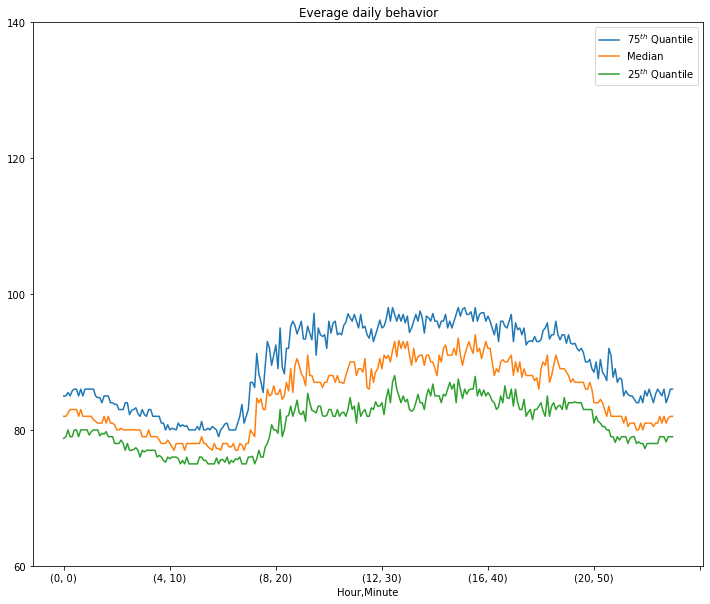

In [424]:
low = 25
up = 75

df_daily_bpm_low = df[['bpm', 'Hour', 'Minute']].groupby(['Hour', 'Minute']).quantile(low/100) #Now df_daily has MultiIndex([(0,  0),...,(0, 45)],names=['Hour', 'Minute'])
df_daily_bpm_Q50 = df[['bpm', 'Hour', 'Minute']].groupby(['Hour', 'Minute']).quantile() #Now df_daily has MultiIndex([(0,  0),...,(0, 45)],names=['Hour', 'Minute'])
df_daily_bpm_up = df[['bpm', 'Hour', 'Minute']].groupby(['Hour', 'Minute']).quantile(up/100) #Now df_daily has MultiIndex([(0,  0),...,(0, 45)],names=['Hour', 'Minute'])


fig, ax = plt.subplots(figsize=(12,10))
df_daily_bpm_up.plot(label=r'$97.5^{th}$ Quantile', ax = ax)
df_daily_bpm_Q50.plot(label='Median', ax = ax)
df_daily_bpm_low.plot(label=r'$2.5^{th}$ Quantile', ax = ax)

plt.title('Everage daily behavior')
ax.set_yticks([60, 80, 100, 120, 140])
plt.legend([ str(up)+r'$^{th}$ Quantile','Median',str(low)+r'$^{th}$ Quantile'])
plt.show()

#### * Observations
* __The daily habitual behavior would be better represented by median behavor ```df_daily_bpm_Q50``` rather than mean behavior ```df_daily_bpm```__, since Median is a more robust estimator than Mean! (Although they actually look quite similar)
 > We would use the data from ```df_daily_bpm_Q50``` to fill in NaN (missing data) in varaible ```bpm```.
* __<span style="color:red">Since the daily median behavior has been built-up from all available data, from now on we choose only the data after *'2020-10-25 01:03:16'.* </span>__

In [425]:
df_daily_bpm_Q50

bpm
Hour Minute       
0    0       82.00
     5       82.00
     10      82.50
     15      83.00
     20      83.00
...            ...
23   35      82.00
     40      81.00
     45      81.75
     50      82.00
     55      82.00

[288 rows x 1 columns]

In [426]:
df = df.loc['2020-10-25 01:03:16':]

In [427]:
df_isna = df[df['bpm'].isna()] #choose the missing data that needs replacement by dictionary of df_daily_bpm_Q50
## df_isna is a "copy" of slice from df, then any alternation of df_isna cannot influence df itself
print(df_isna.index)
df_isna.head(5)

DatetimeIndex(['2020-10-25 05:55:00', '2020-10-25 06:50:00',
               '2020-10-25 07:00:00', '2020-10-25 07:05:00',
               '2020-10-25 07:10:00', '2020-10-25 07:15:00',
               '2020-10-25 07:20:00', '2020-10-25 07:25:00',
               '2020-10-25 07:30:00', '2020-10-25 07:35:00',
               ...
               '2020-12-28 13:10:00', '2020-12-28 13:55:00',
               '2020-12-28 14:05:00', '2020-12-28 14:20:00',
               '2020-12-28 14:35:00', '2020-12-28 15:10:00',
               '2020-12-28 15:40:00', '2020-12-28 16:25:00',
               '2020-12-28 16:50:00', '2020-12-28 17:00:00'],
              dtype='datetime64[ns]', length=5001, freq=None)


,bpm,HF wenn inaktiv,Gehen,Typ,Hour,Minute
2020-10-25 05:55:00,NaN,NaN,NaN,NaN,5,55
2020-10-25 06:50:00,NaN,NaN,NaN,NaN,6,50
2020-10-25 07:00:00,NaN,NaN,NaN,NaN,7,0
2020-10-25 07:05:00,NaN,NaN,NaN,NaN,7,5
2020-10-25 07:10:00,NaN,NaN,NaN,NaN,7,10


In [428]:
df.loc[df['bpm'].isna(), 'bpm']  = df_daily_bpm_Q50.loc[[(i, j) for i, j in zip(df_isna['Hour'].values, df_isna['Minute'].values)]].values
#This does not work!!
#df_isna.loc[:,'bpm'] = df_daily_bpm_Q50.loc[[(i, j) for i, j in zip(df_isna['Hour'].values, df_isna['Minute'].values)]].values


In [429]:
print("Number of missing data for each variable is now:\n",df.isna().sum(axis=0))

Number of missing data for each variable is now:
 bpm                   0
HF wenn inaktiv    5001
Gehen              5001
Typ                5001
Hour                  0
Minute                0
dtype: int64


Next we start fixing missing data from "HF wenn inaktiv", "Gehen", "Typ"

In [430]:
df["HF wenn inaktiv"].fillna(method='ffill', inplace=True)
df["Gehen"].fillna(method='ffill', inplace=True)

* Review:
> - Typ: {'hoher ruhefaktor':0, 'ruhend':1, 'erhöht':2, 'niedrig':3}  
  > niedrig (3)- (0, 50)  
  > ruhend (1)- (50,80)  
  > hoher ruhefaktor (0)-(80,100)  
  > erhöht (2)-(100,inf)

In [431]:
df.loc[df['Typ'].isna(), 'Typ'] = df.loc[df['Typ'].isna(), 'bpm'].map(lambda x: 3 if x<50 else (1 if x<80 else (0 if x<100 else 2)))

In [432]:
print("Number of missing data for each variable is now:\n",df.isna().sum(axis=0))

Number of missing data for each variable is now:
 bpm                0
HF wenn inaktiv    0
Gehen              0
Typ                0
Hour               0
Minute             0
dtype: int64


__Now we get the clean aggregated data!__

## - Clean Data Visualization and Statistics

In [433]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18627 entries, 2020-10-25 01:05:00 to 2020-12-28 17:15:00
Freq: 5T
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bpm              18627 non-null  float64
 1   HF wenn inaktiv  18627 non-null  float64
 2   Gehen            18627 non-null  float64
 3   Typ              18627 non-null  float64
 4   Hour             18627 non-null  int64  
 5   Minute           18627 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 1018.7 KB


In [434]:
df.describe()

,bpm,HF wenn inaktiv,Gehen,Typ,Hour,Minute
count,18627.000000,18627.000000,18627.000000,18627.000000,18627.000000,18627.000000
mean,85.825848,0.798142,0.012401,0.330327,11.470822,27.497182
std,8.924411,0.401397,0.110672,0.561502,6.908628,17.260842
min,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,1.000000,0.000000,0.000000,5.000000,10.000000
50%,85.000000,1.000000,0.000000,0.000000,11.000000,25.000000
75%,90.000000,1.000000,0.000000,1.000000,17.000000,40.000000
max,178.000000,1.000000,1.000000,3.000000,23.000000,55.000000


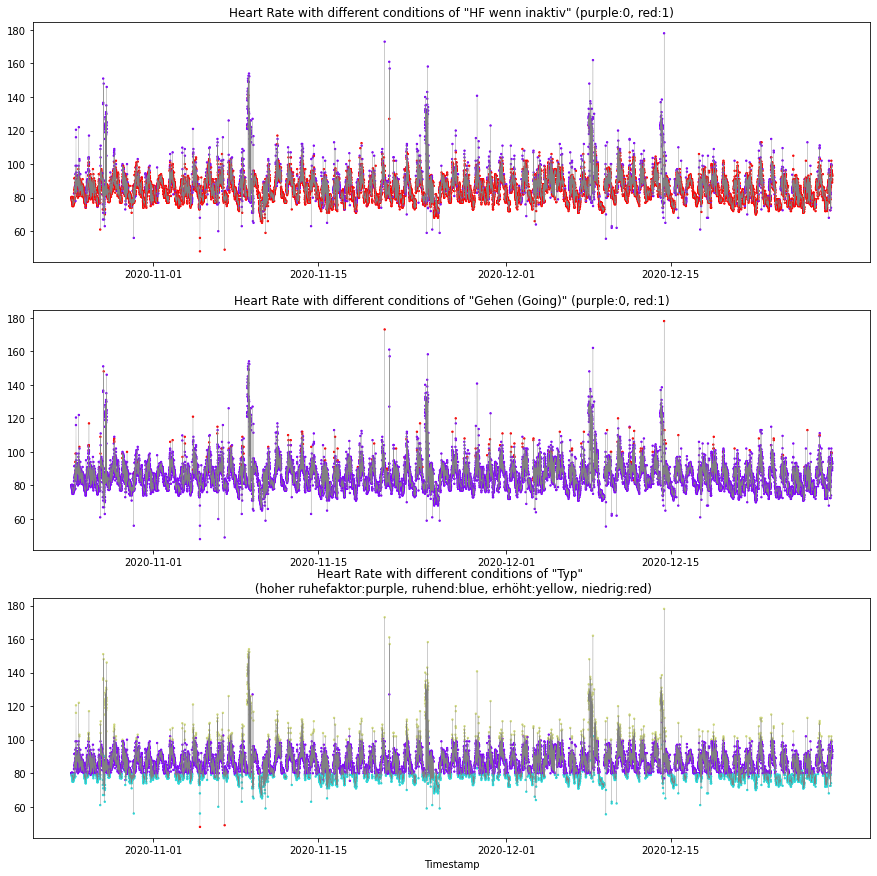

In [435]:
zoom = df#.loc['2020-11-11 00:00': '2020-11-12 00:00']  # '2020-11-10 '

fig, ax = plt.subplots(3,1, figsize=(15,15))
ax[0].plot(zoom.index, zoom['bpm'], linestyle='-', c='grey', linewidth = 0.2)
ax[0].scatter(zoom.index, zoom['bpm'], c=zoom['HF wenn inaktiv'],s=2, cmap='rainbow') 
ax[1].plot(zoom.index, zoom['bpm'], linestyle='-', c='grey', linewidth = 0.2)
ax[1].scatter(zoom.index, zoom['bpm'], c=zoom['Gehen'], s=2, cmap='rainbow')
ax[2].plot(zoom.index, zoom['bpm'], linestyle='-', c='grey', linewidth = 0.2)
ax[2].scatter(zoom.index, zoom['bpm'], c=zoom['Typ'], s=2, cmap='rainbow') 
ax[2].set_xlabel('Timestamp')
ax[0].set_title('Heart Rate with different conditions of "HF wenn inaktiv" (purple:0, red:1)')
ax[1].set_title('Heart Rate with different conditions of "Gehen (Going)" (purple:0, red:1)')
ax[2].set_title('Heart Rate with different conditions of "Typ" \n (hoher ruhefaktor:purple, ruhend:blue, erhöht:yellow, niedrig:red)')

plt.show()
fig.savefig("Clean data visualization (regularized 5min interval).png", dpi = 300, transparent=True)


# 3. Model training and prediction

## 3.1 Model1 – Gaussian HMM with Univariate Observation

In [436]:
from hmmlearn import hmm

In [437]:
Obs = df['bpm'].values.reshape(-1, 1) 

Hid_pre_list = []
logprob_list = []
model_list = []

max_components =6
for s in range(2, max_components+1):
    
    ##load model– Gaussian HMM which is Hidden Markov Model with multinomial (discrete) emissions
    model = hmm.GaussianHMM(n_components=s, covariance_type='diag', n_iter=1000, tol=0.001)
    ##Training and Prediction of Hidden states
    model.fit(Obs)

    Hid_pre = model.predict(Obs)
    Hid_pre_list.append(Hid_pre)
    
    logprob = model.score(Obs) #log-probability of sequence Obs
    logprob_list.append(logprob)
    
    model_list.append(model)
    print("The log-probability of Obs. sequence given {} estimated hidden states is \t: {:.10f}".format(s, logprob))

The log-probability of Obs. sequence given 2 estimated hidden states is 	: -60560.4126593138
The log-probability of Obs. sequence given 3 estimated hidden states is 	: -55997.3302837790
The log-probability of Obs. sequence given 4 estimated hidden states is 	: -53485.9209770188
The log-probability of Obs. sequence given 5 estimated hidden states is 	: -51615.1214622232
The log-probability of Obs. sequence given 6 estimated hidden states is 	: -50470.3829792193


In [448]:
s = 4
model = model_list[s-2]

#Initial state occupation distribution 
print(f"The following result show parameter estimates with {s} hidden states: \n\n")
print("Estimated initial state occupation distribution: \n {} \n".format( model.startprob_))
#Matrix of transition probabilities between states. 
print("Estimated matrix of transition probabilities between states: \n {} \n".format(model.transmat_ ))
#Probability dist. of emission given each state.
print("Mean parameters of Gaussian assumption for each state \n {}\n".format(model.means_))
print("Covariance parameters of Gaussian assumption for each state \n {}\n".format(model.covars_))


The following result show parameter estimates with 4 hidden states: 


Estimated initial state occupation distribution: 
 [1.00000000e+000 2.21012690e-104 9.03806908e-160 1.47533189e-296] 

Estimated matrix of transition probabilities between states: 
 [[9.50818231e-01 4.21135278e-02 6.78001275e-03 2.88228326e-04]
 [3.33191241e-02 9.35031780e-01 6.23703445e-03 2.54120612e-02]
 [3.34112142e-02 1.94614145e-02 8.47787177e-01 9.93401942e-02]
 [1.45214239e-26 3.60595998e-02 1.75525910e-02 9.46387809e-01]] 

Mean parameters of Gaussian assumption for each state 
 [[ 77.8687877 ]
 [ 84.77177592]
 [100.83849115]
 [ 92.02646188]]

Covariance parameters of Gaussian assumption for each state 
 [[[  6.34187092]]

 [[  9.53376626]]

 [[428.52523875]]

 [[ 17.14642139]]]



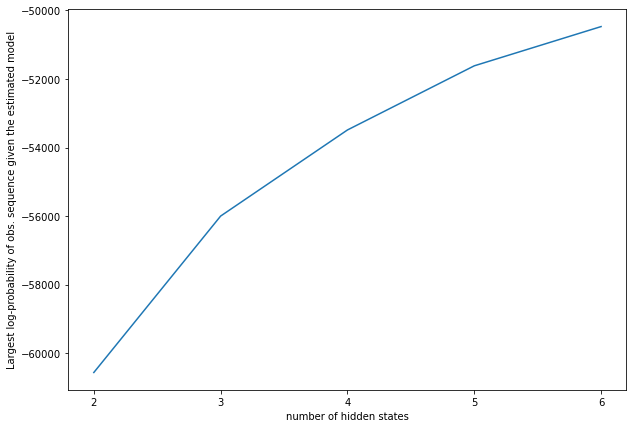

In [438]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(list(range(2,max_components+1)),logprob_list)
ax.set_xticks(list(range(2,max_components+1)))
ax.set_xlabel('number of hidden states')
ax.set_ylabel('Largest log-probability of obs. sequence given the estimated model')
plt.show()

In [439]:
Hid_pre_df = np.array(Hid_pre_list).T
Hid_pre_df = pd.DataFrame(np.array(Hid_pre_list).T, columns =['Hid_pre'+str(s) for s in range(2,max_components+1)], index =  df.index)

In [440]:
df2 = pd.concat([df,Hid_pre_df], axis = 1)
df2.head(5)

,bpm,HF wenn inaktiv,Gehen,Typ,Hour,Minute,Hid_pre2,Hid_pre3,Hid_pre4,Hid_pre5,Hid_pre6
2020-10-25 01:05:00,80.0,1.0,0.0,0.0,1,5,1,0,0,4,5
2020-10-25 01:10:00,80.0,1.0,0.0,0.0,1,10,1,0,0,4,5
2020-10-25 01:15:00,80.0,1.0,0.0,0.0,1,15,1,0,0,4,5
2020-10-25 01:20:00,80.0,1.0,0.0,0.0,1,20,1,0,0,4,5
2020-10-25 01:25:00,80.0,0.0,0.0,0.0,1,25,1,0,0,4,5


### - Visualization for Predicted Hidden States

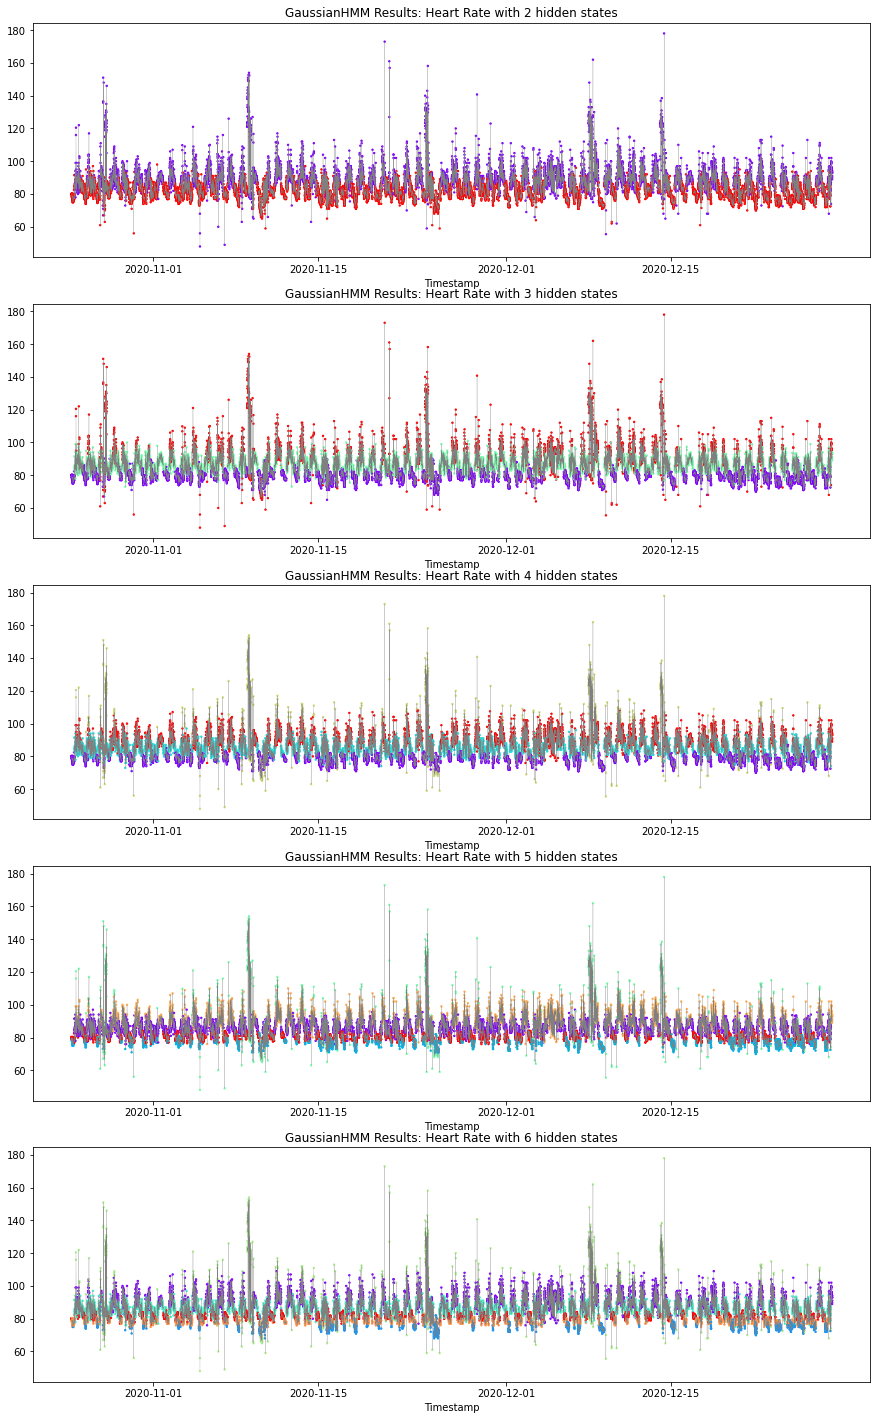

In [442]:
zoom = df2#['2020-12-14 00:00': '2020-12-15 00:00']  # '2020-11-10 '

fig, ax = plt.subplots(max_components-1, 1, figsize=(15,25))
for s in range(2, max_components+1):
    ax[s-2].plot(zoom.index, zoom['bpm'], linestyle='-', c='grey', linewidth = 0.2)
    ax[s-2].scatter(zoom.index, zoom['bpm'], c=zoom['Hid_pre'+str(s)], s=2, cmap='rainbow') 
    ax[s-2].set_xlabel('Timestamp')
    ax[s-2].set_title('GaussianHMM Results: Heart Rate with {} hidden states'.format(s))

plt.show()
plt.close()

#### * Observation

- It seems that no matter what number of hidden states is, the GaussianHMM model tend to detect smaller as well as larger peaks as in the same states. 
- If we'd like to detect the signs of heart attacks, this might cause too many false alarms

#### * Advice

- Let's try another model– GMM-HMM which is more flexible since it's not constrained in Gaussian assumption for the emission probability distribution for each hidden states.
> Any kind of emission probability distributions can be simulated by a mixture of sufficiently large numbers (i.e., parameter $n_mix$ below) of Gaussian models.

## 3.2 Model2 – Gaussian Mixture Model (GMM) HMM with Univariate Observation

In [449]:
Obs = df['bpm'].values.reshape(-1, 1) 

Hid_pre_list = []
logprob_list = []

max_components =6
n_mix = 5 #Number of states in the GMM 
          #(with considerable large numbers, it can simulate any distribution P({Obs.}|S))

for s in range(2, max_components+1):    
    ##load model– Gaussian HMM which is Hidden Markov Model with multinomial (discrete) emissions
    model = hmm.GMMHMM(n_components=s, n_mix=n_mix, covariance_type='diag', n_iter=500, tol=0.001)
    ##Training and Prediction of Hidden states
    model.fit(Obs)
    print(">> \t Does the algorithm converge? \t",model.monitor_.converged) #True

    Hid_pre = model.predict(Obs)
    Hid_pre_list.append(Hid_pre)
    
    logprob = model.score(Obs) #log-probability of sequence Obs
    logprob_list.append(logprob)
    print("The log-probability of Obs. sequence given {} estimated hidden states is \t: {:.10f}".format(s, logprob))

>> 	 Does the algorithm converge? 	 True
The log-probability of Obs. sequence given 2 estimated hidden states is 	: -62818.8960765531
>> 	 Does the algorithm converge? 	 True
The log-probability of Obs. sequence given 3 estimated hidden states is 	: -62815.6705997336
>> 	 Does the algorithm converge? 	 True
The log-probability of Obs. sequence given 4 estimated hidden states is 	: -61874.0567367044
>> 	 Does the algorithm converge? 	 True
The log-probability of Obs. sequence given 5 estimated hidden states is 	: -61478.6433046347
>> 	 Does the algorithm converge? 	 True
The log-probability of Obs. sequence given 6 estimated hidden states is 	: -61859.5608224250


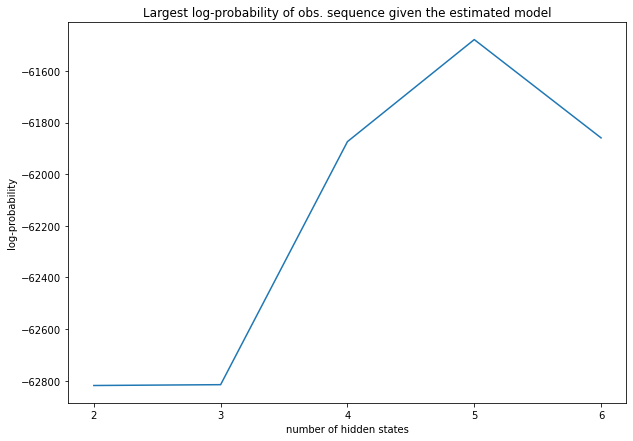

In [450]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(list(range(2,max_components+1)),logprob_list)
ax.set_xticks(list(range(2,max_components+1)))
ax.set_xlabel('number of hidden states')
ax.set_ylabel('log-probability')
ax.set_title('Largest log-probability of obs. sequence given the estimated model')
plt.show()

In [454]:
s = 4
model = model_list[s-2]

#Initial state occupation distribution 
print(f"The following result show parameter estimates with {s} hidden states: \n\n")
print("Estimated initial state occupation distribution: \n {} \n".format( model.startprob_))
#Matrix of transition probabilities between states. 
print("Estimated matrix of transition probabilities between states: \n {} \n".format(model.transmat_ ))
#Probability dist. of emission given each state.
print("Mean parameters of GMM assumption for each state \n {}\n".format(model.means_))
print("Covariance parameters of GMM assumption for each state \n {}\n".format(model.covars_))


The following result show parameter estimates with 4 hidden states: 


Estimated initial state occupation distribution: 
 [1.00000000e+000 2.21012690e-104 9.03806908e-160 1.47533189e-296] 

Estimated matrix of transition probabilities between states: 
 [[9.50818231e-01 4.21135278e-02 6.78001275e-03 2.88228326e-04]
 [3.33191241e-02 9.35031780e-01 6.23703445e-03 2.54120612e-02]
 [3.34112142e-02 1.94614145e-02 8.47787177e-01 9.93401942e-02]
 [1.45214239e-26 3.60595998e-02 1.75525910e-02 9.46387809e-01]] 

Mean parameters of GMM assumption for each state 
 [[ 77.8687877 ]
 [ 84.77177592]
 [100.83849115]
 [ 92.02646188]]

Covariance parameters of GMM assumption for each state 
 [[[  6.34187092]]

 [[  9.53376626]]

 [[428.52523875]]

 [[ 17.14642139]]]



In [452]:
Hid_pre_df = np.array(Hid_pre_list).T
Hid_pre_df = pd.DataFrame(np.array(Hid_pre_list).T, columns =['Hid_pre'+str(s) for s in range(2,max_components+1)], index =  df.index)
df3 = pd.concat([df,Hid_pre_df], axis = 1)
#df3.head(5)

### - Visualization for Predicted Hidden States

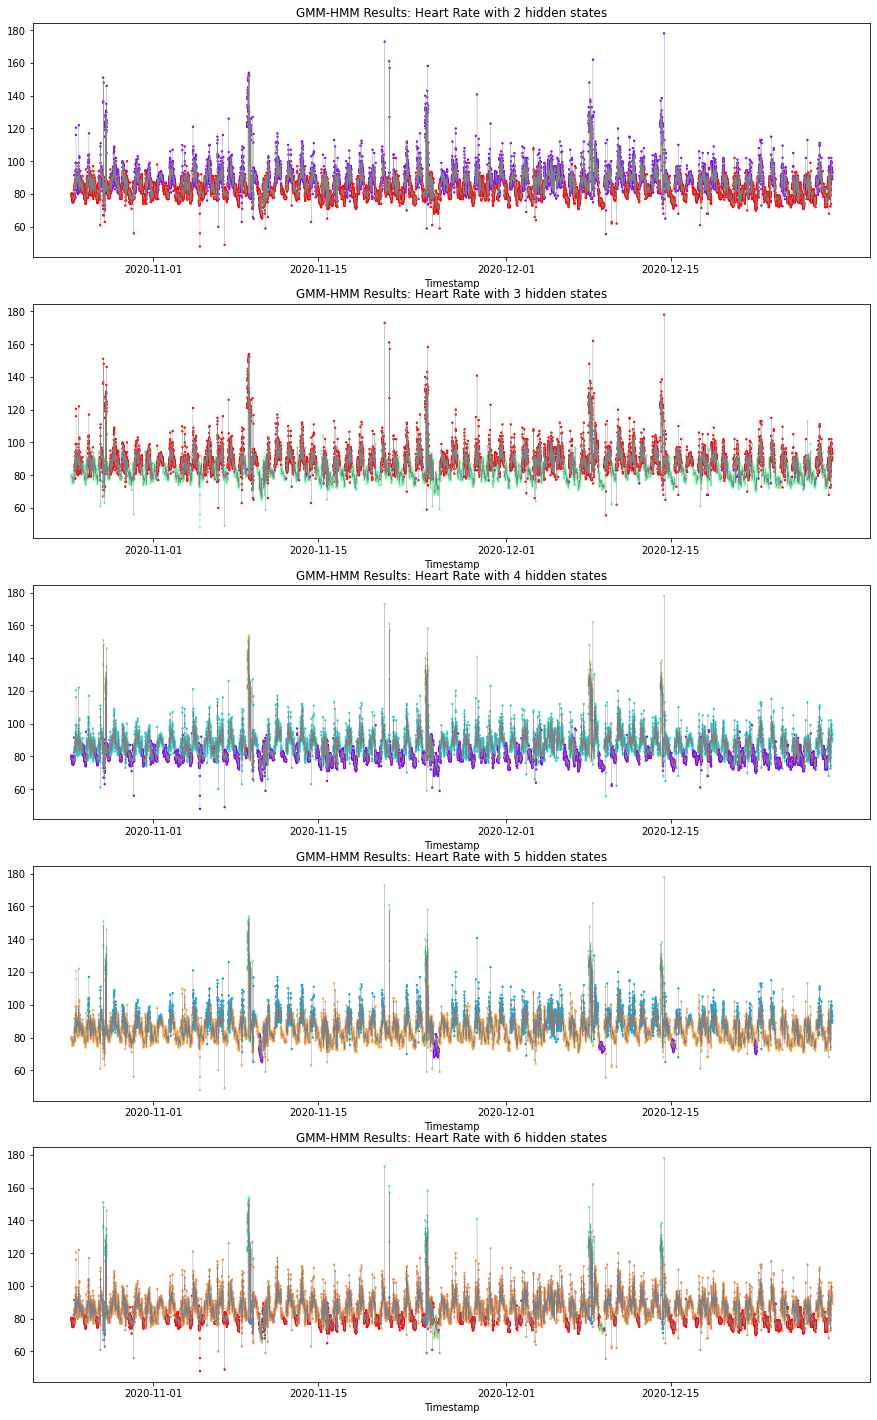

In [453]:
zoom = df3#['2020-12-14 00:00': '2020-12-15 00:00']  # '2020-11-10 '

fig, ax = plt.subplots(max_components-1, 1, figsize=(15,25))
for s in range(2, max_components+1):
    ax[s-2].plot(zoom.index, zoom['bpm'], linestyle='-', c='grey', linewidth = 0.2)
    ax[s-2].scatter(zoom.index, zoom['bpm'], c=zoom['Hid_pre'+str(s)], s=2, cmap='rainbow') 
    ax[s-2].set_xlabel('Timestamp')
    ax[s-2].set_title('GMM-HMM Results: Heart Rate with {} hidden states'.format(s))

plt.show()
plt.close()
fig.savefig("GMM-HMM Results- Heart Rate with different number of hidden states.png", dpi = 300, transparent=True)

#### * Observation

1. According to the log-probability reports, no matter what model (Gaussian or GMM HMM) used, the fitting results are most likely better with more hidden states (parameter $s$) supposed. To decide the best number of $s$, we might look at the changes of log-prob. along with number of hidden states (that is, marginal increase or gain), to see which parameter values drastically improve the model (i.e., higher log-prob. value)

1. Comparing GaussianHMM with GMM-HMM models, it seems GMM-HMM models are better at capturing high peaks (roughly bpm > 140) which indicate potential heart attacks.
> - GMM-HMM with 4 hidden states can sufficiently describe the data transitioning from different states, especially recognizing the one of potential heart attacks. HMM with $s=4$ are decided since it significantly increases log-prob. from that of $s=3$  
> - GMM-HMM with 5 hidden states also works fine since it shows the highest log-prob. (i.e., best model) so far.
